In [24]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import cv2
import os
import json
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from pathlib import Path

# Load Data

In [31]:
TRAIN_DIR = '/Users/liamflynn/Documents/computer_vision/computer_vision/project_pt1/benchmark_velocity_train/clips/'
CLIP_NUMS = [x for x in os.listdir(TRAIN_DIR) if 'DS_Store' not in x]
img_paths = [Path(TRAIN_DIR).joinpath(num).joinpath('imgs').joinpath('040.jpg') for num in CLIP_NUMS]
TRAIN_ANNO = [Path(TRAIN_DIR).joinpath(x).joinpath('annotation.json') for x in CLIP_NUMS]

In [34]:
anno_pth = '/Users/liamflynn/Documents/computer_vision/computer_vision/project_pt1/benchmark_velocity_train/clips/110/annotation.json'
with open(anno_pth) as f:
    anno_data = json.load(f)
    for data in anno_data:
        # Read eachbounding box
        start_point = (int(data['bbox']['left']),int(data['bbox']['top']))
        end_point = (int(data['bbox']['right']),int(data['bbox']['bottom']))
        height = (data['bbox']['bottom'] - data['bbox']['top'])
        width = (data['bbox']['right'] - data['bbox']['left'])

In [35]:
type(all_data)

list

In [41]:
for car in anno_data:
    print(car['bbox'])

{'top': 345.8894958496, 'right': 843.3287963867, 'bottom': 379.8823547363, 'left': 788.3708496094}


# Data Exploration

In [3]:
heights = []
widths = []
for anno_pth in training_annotations:
    # Read annotation data
    with open(anno_pth) as f:
        all_data = json.load(f)
        for data in all_data:
            # Read eachbounding box
            start_point = (int(data['bbox']['left']),int(data['bbox']['top']))
            end_point = (int(data['bbox']['right']),int(data['bbox']['bottom']))
            height = (data['bbox']['bottom'] - data['bbox']['top'])
            width = (data['bbox']['right'] - data['bbox']['left'])
            size =  height * width
            heights.append(height)
            widths.append(width)

In [4]:
df = pd.DataFrame()
df['h'] = heights
df['w'] = widths
df['ratio'] = df['h']/df['w']
df['ratio'].describe()

count    1442.000000
mean        0.765356
std         0.108725
min         0.353803
25%         0.705331
50%         0.771408
75%         0.824876
max         1.464777
Name: ratio, dtype: float64

In [5]:
df['w'].mean(), df['h'].mean(),df['w'].max(), df['h'].max()

(54.20455247320977, 39.7932249854905, 388.898153305, 421.1101226807)

In [6]:
WINDOW_SIZE = (160, 120)
#WINDOW_SIZE = (320, 240)

In [7]:
def load_img_and_bbox(clip_no,train=True):
    '''
    Function to cut sections of image and resize to commmon shape
    '''
    if train:
        dataset_path = training_path
    else:
        dataset_path = test_path
        
    img_pth = os.path.join(dataset_path,f'{str(clip_no)}/imgs/040.jpg')
    anno_pth = os.path.join(dataset_path,f'{str(clip_no)}/annotation.json')
    img = cv2.imread(img_pth)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Read annotation data
    bboxes = []
    with open(anno_pth) as f:
        all_data = json.load(f)
        for data in all_data:
            # Read bounding box
            top = int(data['bbox']['top'])
            bottom = int(data['bbox']['bottom'])
            left = int(data['bbox']['left'])
            right = int(data['bbox']['right'])
            bboxes.append((top,bottom,left,right))
    return clip_no, img, bboxes
    
    

In [8]:
def calc_iou(boxA, boxB):
    
    # Calc intersection box
    # Top
    intTop = max(boxA[0], boxB[0])
    # Bottom
    intBottom = min(boxA[1], boxB[1])
    # Left
    intLeft = max(boxA[2], boxB[2])
    # Right
    intRight = min(boxA[3], boxB[3])
    # compute the area of intersection rectangle
    intArea = max(0, intRight - intLeft) * max(0, intBottom - intTop)
    # calculate box A, box B areas
    boxAArea = (boxA[1] - boxA[0]) * (boxA[3] - boxA[2])
    boxBArea = (boxB[1] - boxB[0]) * (boxB[3] - boxB[2])
    # Calc IOU
    iou = intArea / float(boxAArea + boxBArea - intArea)
    return iou

In [9]:
def sliding_window(image, stepSize, windowSize,boxA):
    # slide a window across the image
    for y in range(0, image.shape[0], stepSize):
        for x in range(0, image.shape[1], stepSize):
            # yield the current window
            left = x
            top = y
            right = x + windowSize[0]
            bottom = y  + windowSize[1]
            boxB = (top, bottom, left, right)
            iou = calc_iou(boxA, boxB)
            yield (top, bottom, left, right, iou, image[y:y + windowSize[1], x:x + windowSize[0]])

In [10]:
def image_with_annotation(clip_no,train=True,best_window=True, prediction=True):
    
    clip_no, img, bboxes = load_img_and_bbox(clip_no,train)
    for bbox in bboxes:
        top, bottom, left, right = bbox
        start_point = (left, top)
        end_point = (right, bottom)  
        color =  (0, 255, 0)
        thickness = -1
        # Add bounding box
        img = cv2.rectangle(img, start_point, end_point, color, thickness) 
    
    if best_window:
        boxA = (top, bottom, left, right)
        # Calculate all sliding windows and their IOU with ground truth
        windows = list(sliding_window(img, stepSize=12, windowSize=WINDOW_SIZE, boxA=boxA))
        (top, bottom, left, right, iou) = max(windows, key=lambda x:x[4])[0:5]
        color =  (255, 0, 0)
        thickness = 2
        start_point = (left, top)
        end_point = (right, bottom) 
        # Add bounding box
        img = cv2.rectangle(img, start_point, end_point, color, thickness) 
    
    
    fig, ax1 = plt.subplots(1, 1,figsize=(20,10))
    fig.suptitle(f'Image: {clip_no}')
    ax1.imshow(img)
    ax1.set_title('Original Image')
    
    return

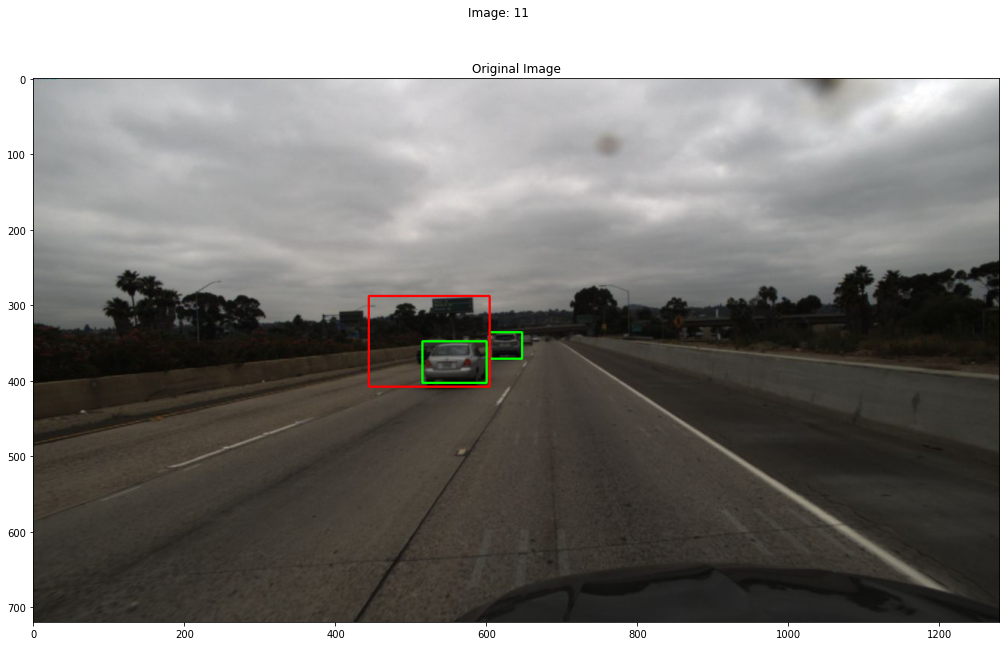

In [11]:
image_with_annotation('11',train=True,best_window=True)

In [12]:
clip_no, img, bboxes = load_img_and_bbox(training_clips[100])

In [13]:
boxA = bboxes[0]
windows = list(sliding_window(img, stepSize=60, windowSize=WINDOW_SIZE,boxA=boxA))
best_window = max(windows, key=lambda x:x[4])

In [14]:
def cut_and_scale(img, top, bottom, left, right,show=True):
    '''
    Function to cut sections of image and resize to commmon shape
    '''
    boxA = (top, bottom, left, right)    
    crop_img = img[top:bottom,left:right,:]
    resized_img = cv2.resize(crop_img, WINDOW_SIZE) 
    if show:

        fig, ax1 = plt.subplots(1, 1,figsize=(20,10))
        ax1.imshow(resized_img)
    else:
        return resized_img
    

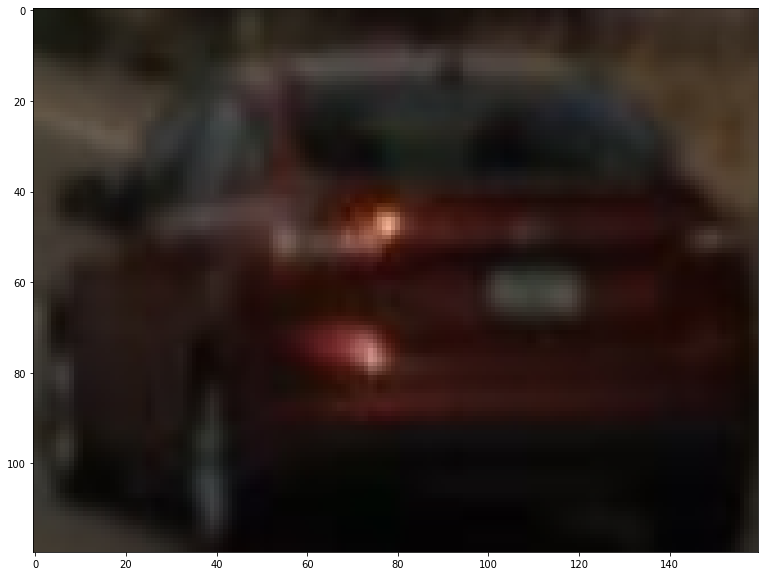

In [15]:
clip_no, img, bboxes = load_img_and_bbox(training_clips[100])
top, bottom, left, right = bboxes[0]
cut_and_scale(img, top, bottom, left, right,show=True)

# Feature Extraction

In [16]:
def generate_windows_and_ious(clip_no,stepSize,train=True):
    '''
    Function to cut sections of image and resize to commmon shape
    '''
    clip_no, img, bboxes = load_img_and_bbox(clip_no,train)
    num_boxes = 1
    for boxA in bboxes:
        # Calculate all sliding windows and their IOU with ground truth bboxes
        if num_boxes == 1:
            windows = list(sliding_window(img, stepSize=stepSize, windowSize=WINDOW_SIZE, boxA=boxA))
        else:
            num_boxes +=1
            windows += list(sliding_window(img, stepSize=stepSize, windowSize=WINDOW_SIZE, boxA=boxA))
        
    return windows

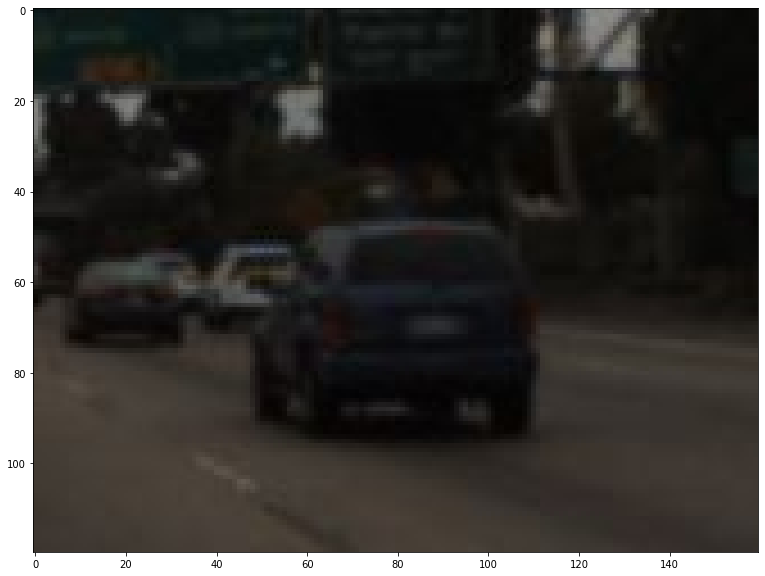

In [17]:
clip_no = test_clips[100]
train = True
windows = generate_windows_and_ious(clip_no,stepSize=48,train=train)
clip_no, img, bboxes = load_img_and_bbox(clip_no,train=train)
best_window = max(windows, key=lambda x:x[4])
top, bottom, left, right = best_window[0:4]
cut_and_scale(img, top, bottom, left, right,show=True)

In [18]:
def save_object(obj,name):
    with open(f'{name}.pkl', 'wb') as file:
        pickle.dump(obj, file)

In [19]:
def load_object(name):
    with open(f'{name}.pkl', 'rb') as file:
        obj = pickle.load(file)
    return obj

In [20]:
def generate_X_and_Y(train=True,stepSize=48,orientations=8,ppc=16,cpb=4):
    X = []
    y = []
    
    if train:
        clips = training_clips
    else:
        clips = test_clips

    for clip_no in tqdm(clips):
        windows = generate_windows_and_ious(clip_no,stepSize=stepSize,train=train)
        for window in windows:
            img = window[5]
            # Only use full images
            if img.shape[0:2]==(WINDOW_SIZE[1],WINDOW_SIZE[0]):
                X.append(hog(img, orientations=orientations, pixels_per_cell=(ppc,
                        ppc),cells_per_block=(cpb, cpb),block_norm= 'L2'))
                y.append(window[4])

    X = np.array(X)
    y = np.array(y)
    
    return X,y

In [21]:
for stepSize in [60,120]:
    for ppc in [16]:
        for orients in [4,9]:
            for cpb in [4]:
                print(f'{stepSize}_{orients}_{ppc}_{cpb}')
                X_train, y_train = generate_X_and_Y(train=True,stepSize=stepSize,orientations=orients,ppc=ppc,cpb=cpb)
                X_test, y_test = generate_X_and_Y(train=False,stepSize=stepSize,orientations=orients,ppc=ppc,cpb=cpb)
                save_object(X_test,f'X_test_{stepSize}_{orients}_{ppc}_{cpb}')
                save_object(X_train,f'X_train_{stepSize}_{orients}_{ppc}_{cpb}')
                save_object(y_test,f'y_test_{stepSize}_{orients}_{ppc}_{cpb}')
                save_object(y_train,f'y_train_{stepSize}_{orients}_{ppc}_{cpb}')

60_4_16_4


  0%|          | 0/1074 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

60_9_16_4


  0%|          | 0/1074 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

120_4_16_4


  0%|          | 0/1074 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

120_9_16_4


  0%|          | 0/1074 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

# Model Fitting

In [82]:
stepSize = 120
ppc = 16
orients = 9
cpb = 4
X_test = load_object(f'X_test_{stepSize}_{orients}_{ppc}_{cpb}')
X_train = load_object(f'X_train_{stepSize}_{orients}_{ppc}_{cpb}')
y_test = load_object(f'y_test_{stepSize}_{orients}_{ppc}_{cpb}')
y_train = load_object(f'y_train_{stepSize}_{orients}_{ppc}_{cpb}')

In [24]:
reg = LinearRegression().fit(X_train, y_train)
reg.score(X_test, y_test)

0.04118975498459476

In [25]:
reg.score(X_test,y_test)

0.04118975498459476

In [26]:
rf = RandomForestRegressor(min_samples_split=0.01,max_features='sqrt').fit(X_train, y_train)
rf.score(X_train, y_train)

0.26689457899957614

In [27]:
rf.score(X_test, y_test)

0.12606984367230545

# Inference

In [28]:
def make_prediction(clip_no,model,stepSize=48,orientations=8,ppc=16,cpb=4,train=False):
    '''
    Make prediction returns the coordinates of window with the highest predicted IoU
    '''
    X = []
    y = []
    windows = generate_windows_and_ious(clip_no,stepSize,train=train)
    window = windows[0]
    img = window[5]
    num_feats = len(hog(img, orientations=orientations, pixels_per_cell=(ppc,
                        ppc),cells_per_block=(cpb, cpb),block_norm= 'L2'))
    X = np.zeros((len(windows),num_feats))

    for n in range(len(windows)):
        window = windows[n]
        img = window[5]
        # Only use full images
        if img.shape[0:2]==(WINDOW_SIZE[1],WINDOW_SIZE[0]):
            X[n,:] = hog(img, orientations=orientations, pixels_per_cell=(ppc,
                        ppc),cells_per_block=(cpb, cpb),block_norm= 'L2')
    
    y = model.predict(X)
    max_ind = y.argmax()
    max_window = windows[max_ind]
    # Max IOU window/s available
    max_iou = max(windows, key=lambda x:x[4])[4]
    best_windows = [x[0:4] for x in windows if x[4]==max_iou]
    non_zero_windows = [x[0:4] for x in windows if x[4]>0]
    picked_best = 1 if max_window[0:4] in best_windows else 0
    # Top 5 predictions
    top5_idx = y.argsort()[-5:][::-1]
    top5_windows = [windows[idx][0:4] for  idx in top5_idx]
    # Intersection of highest IoU window (possibly multiple with same IoU) and top 5 preds
    intersection = [window for window in top5_windows if window in best_windows]
    best_in_top5 = 1 if len(intersection)>0 else 0 
    
    return X,y,max_window,picked_best,best_in_top5


In [67]:
clip_no = test_clips[100]
model = rf
X,y,max_window,picked_best,best_in_top5 = make_prediction(clip_no,model,stepSize,orients,ppc,cpb,False)


In [80]:
def show_prediction(clip_no,model,stepSize,orientations,ppc,cpb,train=False):
    
    clip_no, img, bboxes = load_img_and_bbox(clip_no,train)
    X,y,prediction,_,_ = make_prediction(clip_no,model,stepSize,orientations,ppc,cpb,train=False)
    
    for bbox in bboxes:
        top,bottom,left,right = bbox
        start_point = (left, top)
        end_point = (right, bottom)  
        color =  (0, 255, 0)
        thickness = 2
        # Add Ground Truth
        img = cv2.rectangle(img, start_point, end_point, color, thickness) 
    
    # Add prediction
    (top, bottom, left, right) = prediction[0:4]
    color =  (255, 0, 0)
    thickness = 2
    start_point = (left, top)
    end_point = (right, bottom) 
    img = cv2.rectangle(img, start_point, end_point, color, thickness) 
    
    
    fig, ax1 = plt.subplots(1, 1,figsize=(20,10))
    ax1.imshow(img)
    ax1.set_title(f'Image {clip_no} Prediction',fontsize=20)
    plt.savefig('Prediction.png')
    
    return

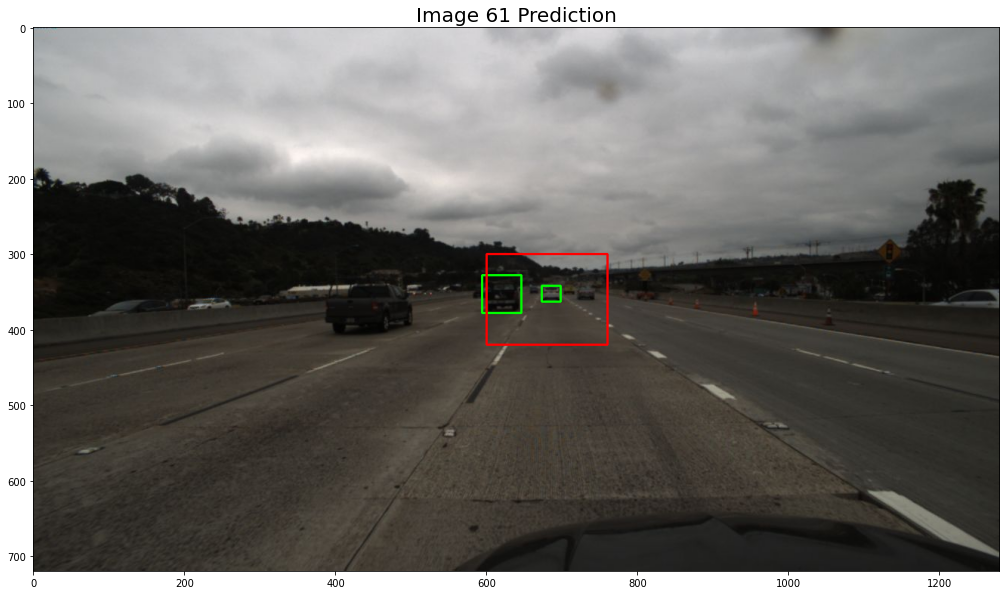

In [81]:
clip_no = test_clips[1]
clip_no, img, bboxes = load_img_and_bbox(clip_no,train=train)
best_window = max(windows, key=lambda x:x[4])[0:4]
show_prediction(clip_no,model,stepSize,orients,ppc,cpb,train=False)

# Evaluation Metrics

In [32]:
def baseline_iou(stepSize,train=False):
    '''
    Calculate the average IoU of all windows in all Images to use as a baseline comparison.
    '''

    all_ious = []

    for clip_no in tqdm(test_clips):
        windows = generate_windows_and_ious(clip_no,stepSize,train)
        all_ious.extend([x[4] for x in windows])

    average_iou = sum(all_ious)/len(all_ious)
    non_zeros = len([iou for iou in all_ious if iou > 0])/len(all_ious)
    
    return average_iou, non_zeros

In [33]:
baseline, nonzero_perc = baseline_iou(stepSize,train=False)
baseline, nonzero_perc

  0%|          | 0/269 [00:00<?, ?it/s]

(0.0019093871894393134, 0.0488340655626901)

In [34]:
def grade_model(model,X_test, y_test,stepSize,orientations,ppc,cpb):
    
    r2 = model.score(X_test, y_test)
    
    
    res_df = pd.DataFrame(index=test_clips,columns=['pred_iou','picked_best','best_in_top5'])

    for clip_no in tqdm(test_clips):
        X, y, prediction, picked_best, best_in_top5 = make_prediction(clip_no,model,stepSize,orients,ppc,cpb,train)
        box_pred = prediction[0:4]
        iou = 0
        clip_no, img, bboxes = load_img_and_bbox(clip_no,train)
        for bbox in bboxes:
            iou += calc_iou(box_pred, bbox)
            
        res_df.loc[clip_no,'pred_iou'] = iou
        res_df.loc[clip_no,'picked_best'] = picked_best
        res_df.loc[clip_no,'best_in_top5'] = best_in_top5
    
    
    res_df['pred_iou'] = res_df['pred_iou'].astype(float)  
    # Average IOU for random window in image
    baseline, nonzero_perc = baseline_iou(stepSize,train=False)
    mean_iou,picked_best,top5 = res_df.mean().values
    iou_mult = float(mean_iou/baseline)
    
    return r2,picked_best,top5,iou_mult
    

In [35]:
r2,picked_best,top5,iou_mult = grade_model(rf,X_test, y_test,stepSize,orients,ppc,cpb)

  0%|          | 0/269 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

In [36]:
r2,picked_best,top5,iou_mult = grade_model(rf,X_test, y_test,stepSize,orients,ppc,cpb)
r2,picked_best,top5,iou_mult

  0%|          | 0/269 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

(0.12606984367230545,
 0.44609665427509293,
 0.895910780669145,
 31.991547523837657)

In [37]:
r2,picked_best,top5,iou_mult = grade_model(reg,X_test, y_test,stepSize,orients,ppc,cpb)
r2,picked_best,top5,iou_mult

  0%|          | 0/269 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

(0.04118975498459476,
 0.2936802973977695,
 0.49814126394052044,
 25.07871064094124)

## Generate Results Table

In [ ]:
df = pd.DataFrame(columns=['Model','R^2','Picked_Best','Top_5','IOU Mult'])
for stepSize in [60,120]:
    for ppc in [16]:
        for orients in [4,9]:
            for cpb in [4]:
                # Load Datasets
                print(f'{stepSize}_{orients}_{ppc}_{cpb}')
                X_test = load_object(f'X_test_{stepSize}_{orients}_{ppc}_{cpb}')
                X_train = load_object(f'X_train_{stepSize}_{orients}_{ppc}_{cpb}')
                y_test = load_object(f'y_test_{stepSize}_{orients}_{ppc}_{cpb}')
                y_train = load_object(f'y_train_{stepSize}_{orients}_{ppc}_{cpb}')
                # Fit Models or load them from filesystem
                try:
                    reg = load_object(f'reg_{stepSize}_{orients}_{ppc}_{cpb}')
                except:
                    reg = LinearRegression().fit(X_train, y_train)
                    save_object(reg,f'reg_{stepSize}_{orients}_{ppc}_{cpb}')
                    
                    
                # Grade Regression Model
                r2,picked_best,top5,iou_mult = grade_model(reg,X_test, y_test,stepSize,orients,ppc,cpb)
                model_name = f'Reg:{stepSize}/{orients}/{ppc}/{cpb}'
                df.loc[len(df)] = model_name, r2,picked_best,top5,iou_mult
                
                if X_train.size < 500000000:
                    try:
                        rf = load_object(f'rf_{stepSize}_{orients}_{ppc}_{cpb}')
                    except:
                        rf = RandomForestRegressor(min_samples_split=0.01,max_features='sqrt').fit(X_train, y_train)
                        save_object(rf,f'rf_{stepSize}_{orients}_{ppc}_{cpb}')

                    # Grade Random Forest Model
                    r2,picked_best,top5,iou_mult = grade_model(rf,X_test, y_test,stepSize,orients,ppc,cpb)
                    model_name = f'RF:{stepSize}/{orients}/{ppc}/{cpb}'
                    df.loc[len(df)] = model_name, r2,picked_best,top5,iou_mult

In [49]:
df

,Model,R^2,Picked_Best,Top_5,IOU Mult
0,Reg:60/4/16/4,0.043878,0.356877,0.762082,25.824851
1,RF:60/4/16/4,0.077222,0.550186,0.921933,43.763433
2,Reg:60/9/16/4,0.076001,0.483271,0.855019,37.128646
3,Reg:120/4/16/4,0.041190,0.293680,0.498141,25.078711
4,RF:120/4/16/4,0.123790,0.438662,0.884758,31.601787
5,Reg:120/9/16/4,0.005511,0.327138,0.713755,28.697914


In [61]:
df.index = df.Model
df

,Model,R^2,Picked_Best,Top_5,IOU Mult
Model,,,,,
Reg:60/4/16/4,Reg:60/4/16/4,0.043878,0.356877,0.762082,25.824851
RF:60/4/16/4,RF:60/4/16/4,0.077222,0.550186,0.921933,43.763433
Reg:60/9/16/4,Reg:60/9/16/4,0.076001,0.483271,0.855019,37.128646
Reg:120/4/16/4,Reg:120/4/16/4,0.041190,0.293680,0.498141,25.078711
RF:120/4/16/4,RF:120/4/16/4,0.123790,0.438662,0.884758,31.601787
Reg:120/9/16/4,Reg:120/9/16/4,0.005511,0.327138,0.713755,28.697914


# Unused 

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=100)
pca.fit(X_train)
X_train2 = pca.transform(X_train)
X_test2 = pca.transform(X_test)

In [ ]:
# Make the Target categorical to make it a classification problem
thresh = 0.0
y_train_binary = y_train.copy()
y_train_binary[y_train_binary<thresh] = 0
y_train_binary[y_train_binary>thresh] = 1
#
y_test_binary = y_test.copy()
y_test_binary[y_test_binary<thresh] = 0
y_test_binary[y_test_binary>thresh] = 1

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification

clf = make_pipeline(StandardScaler(),LinearSVC(random_state=0, tol=1e-5,max_iter=10000))
clf.fit(X_train2, y_train_binary)

In [ ]:
clf.score(X_test2, y_test_binary)
y_pred = clf.predict(X_test2)

In [ ]:
clf.predict(X_test2)

# Biblio
- Sliding Window - https://www.pyimagesearch.com/2015/03/23/sliding-windows-for-object-detection-with-python-and-opencv/
- HOG SVM Tutorial - https://www.pyimagesearch.com/2014/11/10/histogram-oriented-gradients-object-detection/
- IOU - https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/
- SKLearn HOG - https://www.analyticsvidhya.com/blog/2019/09/feature-engineering-images-introduction-hog-feature-descriptor/
- Object Detection - https://www.hindawi.com/journals/tswj/2014/196251/?fbclid=IwAR3tW-4DdisNc8VkYWbIDshbTOGSdxjlMTsyifia9PCQEutI3zr4WtoyXNs
- HOG - https://www2.cs.duke.edu/courses/fall15/compsci527/notes/hog.pdf
- HOG - http://lear.inrialpes.fr/people/triggs/pubs/Dalal-cvpr05.pdf